In [1]:
import os
import re
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from skimage import io
from tifffile import imsave

from image_arrays import *
from s2p_packer import unpack_hdf

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# interactive plotting (outside or within notebook)
# %matplotlib qt
%matplotlib notebook

In [2]:
base_path = "/mnt/Data/prerna_noise/"
# data_path = base_path + "second_batch/originals/"
data_path = base_path + "second_batch/bigger_diam/"
s2p_path = data_path + "s2p/"

In [3]:
raw_noise = io.imread(os.path.join(base_path, "noise_stimulus.tif"))
print("raw noise shape:", raw_noise.shape)
zoom_noise = simple_upsample_2D(raw_noise, 16, 16)
print("zoom noise shape:", zoom_noise.shape)
# 60Hz for 60s after 10s delay
noise_xaxis = np.arange(3600) * (1 / 60) + 10.

raw noise shape: (3600, 16, 16)
zoom noise shape: (3600, 256, 256)


<IPython.core.display.Javascript object>


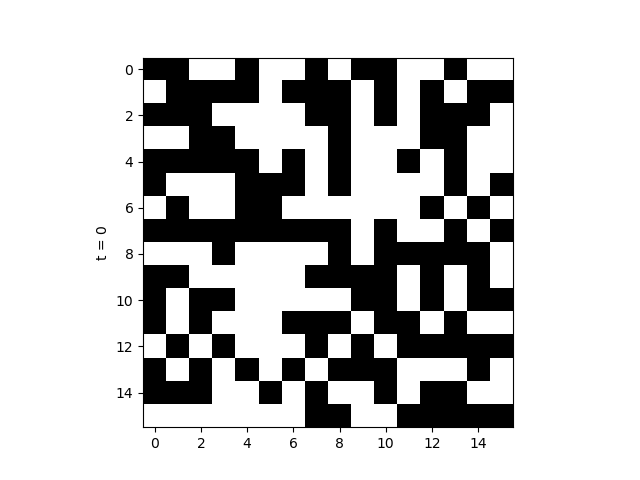

In [4]:
raw_noise_stack_fig, raw_noise_stack_ax = plt.subplots(1)
raw_noise_stack = StackPlotter(raw_noise_stack_ax, raw_noise)
raw_noise_stack.connect_scroll(raw_noise_stack_fig)

In [75]:
# zoom_noise_stack_fig, zoom_noise_stack_ax = plt.subplots(1)
# zoom_noise_stack = StackPlotter(zoom_noise_stack_ax, zoom_noise)
# zoom_noise_stack.connect_scroll(zoom_noise_stack_fig)

<IPython.core.display.Javascript object>


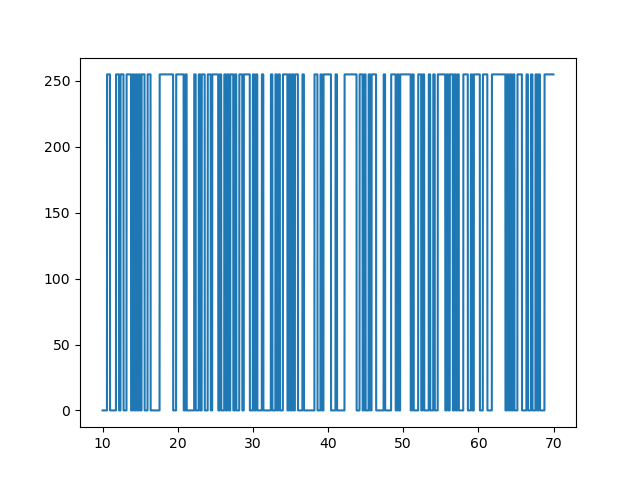

In [6]:
noise_beam_fig, noise_beam_ax = plt.subplots(1)
noise_beam_ax.plot(noise_xaxis, raw_noise[:, 0, 0])

In [7]:
fnames = [
    f for f in os.listdir(data_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:
  scan14_00051_DD_ch1_400um.tif
  scan14_00051_PD_ch1_400um.tif
  scan14_00055_DD_ch1_200um.tif
  scan14_00055_PD_ch1_200um.tif
  scan9_00035_DD_ch1_400um.tif
  scan9_00035_PD_ch1_400um.tif
  scan9_00040_DD_ch1_200um.tif
  scan9_00040_PD_ch1_200um.tif


In [8]:
ex_name = "scan9_00040_PD_ch1_200um"
ex_stack = io.imread(os.path.join(data_path, ex_name + ".tif"))
with h5.File(os.path.join(s2p_path, ex_name + ".h5"), "r") as f:
    ex_s2p = unpack_hdf(f)

<IPython.core.display.Javascript object>


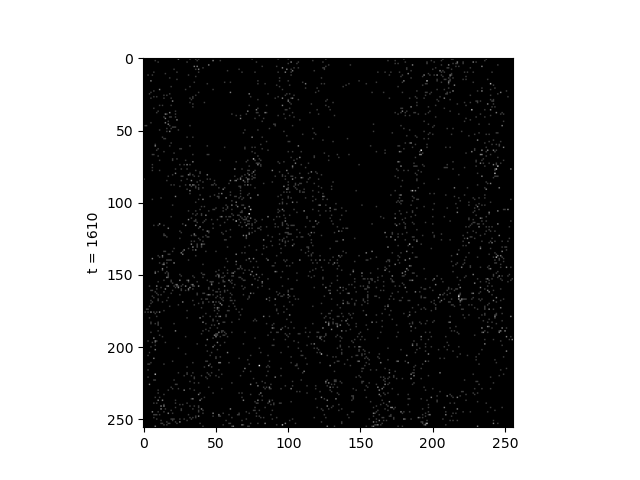

In [9]:
ex_stack_fig, ex_stack_ax = plt.subplots(1)
ex_stack_plot = StackPlotter(ex_stack_ax, ex_stack)
ex_stack_plot.connect_scroll(ex_stack_fig)

<IPython.core.display.Javascript object>


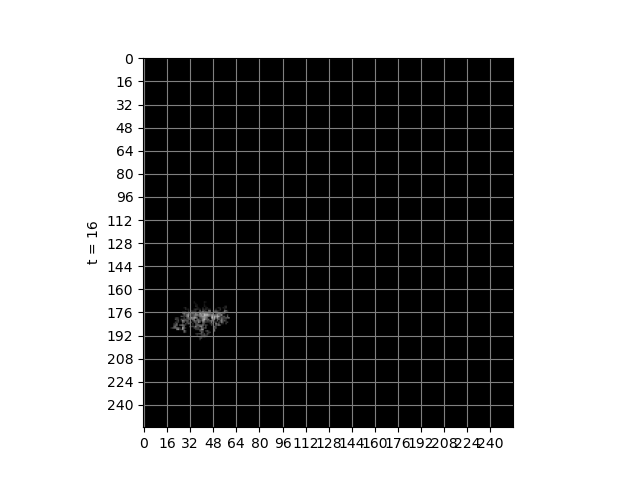

In [12]:
mask_stack = ex_s2p["masks"].transpose(2, 0, 1)
mask_stack_fig, mask_stack_ax = plt.subplots(1)
mask_stack_plot = StackPlotter(mask_stack_ax, mask_stack, delta=1)
mask_stack_plot.connect_scroll(mask_stack_fig)

# gridlines corresponding to noise stimulus
loc = plticker.MultipleLocator(base=16)
mask_stack_ax.xaxis.set_major_locator(loc)
mask_stack_ax.yaxis.set_major_locator(loc)
mask_stack_ax.grid(which='major', axis='both', linestyle='-', c="grey")

In [45]:
recs = ex_s2p["recs"] - ex_s2p["Fneu"] * 0.7
recs_xaxis = np.arange(1700) * 0.05  # 20Hz sampling rate

# normalize to noise and remove offset
recs /= np.var(recs[:, :198], axis=1).reshape(-1, 1)
recs -= np.mean(recs[:, :198], axis=1).reshape(-1, 1)

In [43]:
def butter_bandpass(lowcut, highcut, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order=3):
    b, a = butter_bandpass(lowcut, highcut, sample_rate, order=order)
    y = signal.lfilter(b, a, data)
    return y


# filtered = np.stack([butter_bandpass_filter(roi, 0.0001, 2, 40) for roi in recs], axis=0)
filtered = np.stack([signal.savgol_filter(roi, 9, 2) for roi in recs], axis=0)

<IPython.core.display.Javascript object>


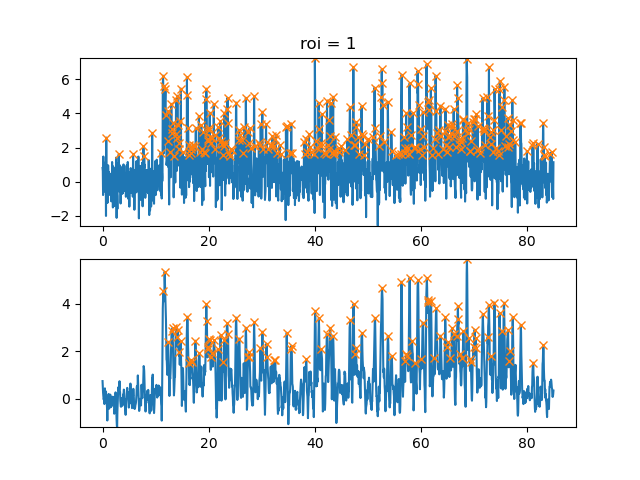

In [76]:
# TODO: should filter out the ROIs that do not meet a certain
# signal to noise criteria, right now, many are duds.

"""
TODO: extract into a class pretty much like StackPlotter, but for
multiple panels that share an index? axis.plot method returns a list
of lines, which is why I am zero indexing here. Another issue to
consider is that either recaling on update will need to be done,
or setting and sticking to a particular range. Can probably get away
with that here, but there might be big outliers which will scrunch
the rest.
"""

beam_idx = 0
n_beams = recs.shape[0]
beams_fig, beams_ax = plt.subplots(2)
thresh = 1.5
raw_peaks, _ = signal.find_peaks(recs[beam_idx], height=thresh)
filt_peaks, _ = signal.find_peaks(filtered[beam_idx], height=thresh)
lines = [
    [
        beams_ax[0].plot(recs_xaxis, recs[beam_idx]),
        beams_ax[0].plot(recs_xaxis[raw_peaks], recs[beam_idx, raw_peaks], "x"),
    ],
    [ 
        beams_ax[1].plot(recs_xaxis, filtered[beam_idx]),
        beams_ax[1].plot(recs_xaxis[filt_peaks], filtered[beam_idx, filt_peaks], "x"),
    ]
]

beams_ax[0].set_ylim(recs.min(), recs.max())
beams_ax[1].set_ylim(filtered.min(), filtered.max())


def beams_update():
    beams_ax[0].set_title("roi = %i" % beam_idx)
    for ax, ln, data in zip(beams_ax, lines, [recs, filtered]):
        ln[0][0].set_ydata(data[beam_idx])
        peaks, _ = signal.find_peaks(data[beam_idx], height=thresh)                             
        ln[1][0].set_data(recs_xaxis[peaks], data[beam_idx, peaks])
        ax.set_ylim(data[beam_idx].min(), data[beam_idx].max())
        beams_fig.canvas.draw()
        

def beams_onscroll(event):
    global beam_idx
    if event.button == "up":
        beam_idx = (beam_idx + 1) % n_beams
    else:
        beam_idx = (beam_idx - 1) % n_beams
    beams_update()

beams_fig.canvas.mpl_connect("scroll_event", beams_onscroll)
beams_update()

In [93]:
def nearest_index(arr, v):
    return np.abs(arr - v).argmin()

def rough_triggers(rec_t, stim_t, rec, thresh, delay):
    times = rec_t[rec > thresh] - delay
    return np.array([nearest_index(stim_t, t) for t in times if t >= np.min(stim_t) and t <= np.max(stim_t)])

def lead_window(stim_t, stim, stop, duration):
    start_idx = nearest_index(stim_t, stop - duration)
    stop_idx = nearest_index(stim_t, stop)
    return stim[start_idx:stop_idx, :, :]

def avg_trigger_window(stim_t, stim, rec_t, rec, thresh, duration):
    idxs, _ = signal.find_peaks(rec, height=thresh)
    times = rec_t[idxs]
    avg = np.mean([
        lead_window(stim_t, stim, t, duration) 
        for t in times if t - duration > np.min(stim_t) and t <= np.max(stim_t)
    ], axis=0)
    return len(idxs), avg

<IPython.core.display.Javascript object>


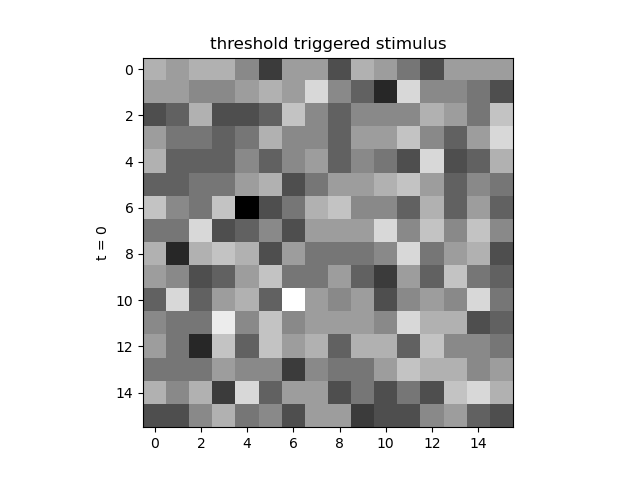

<IPython.core.display.Javascript object>


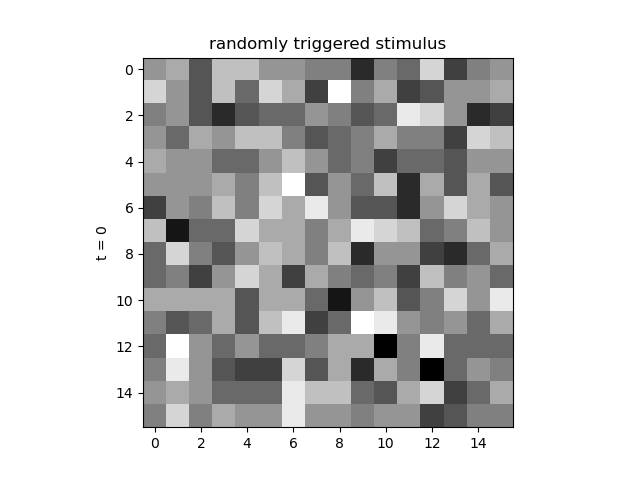

Text(0.5, 1.0, 'randomly triggered stimulus')

In [111]:
lead = 0.9
n_triggers, lead_stack = avg_trigger_window(
    noise_xaxis, 
    raw_noise,
    recs_xaxis,
    recs[15],
    4,
    lead
)

lead_stack_fig, lead_stack_ax = plt.subplots(1)
lead_stack_plot = StackPlotter(lead_stack_ax, lead_stack, delta=1)
lead_stack_plot.connect_scroll(lead_stack_fig)
lead_stack_ax.set_title("threshold triggered stimulus")

# example number of randomly chosen trigger times
ts = np.random.uniform(
    low=(np.min(noise_xaxis) + lead), 
    high=np.max(noise_xaxis),
    size=n_triggers
)
random_lead_stack = np.mean([
    lead_window(noise_xaxis, raw_noise, t, lead) for t in ts
], axis=0)

random_lead_stack_fig, random_lead_stack_ax = plt.subplots(1)
random_lead_stack_plot = StackPlotter(
    random_lead_stack_ax, random_lead_stack, delta=1)
random_lead_stack_plot.connect_scroll(random_lead_stack_fig)
random_lead_stack_ax.set_title("randomly triggered stimulus")

<IPython.core.display.Javascript object>


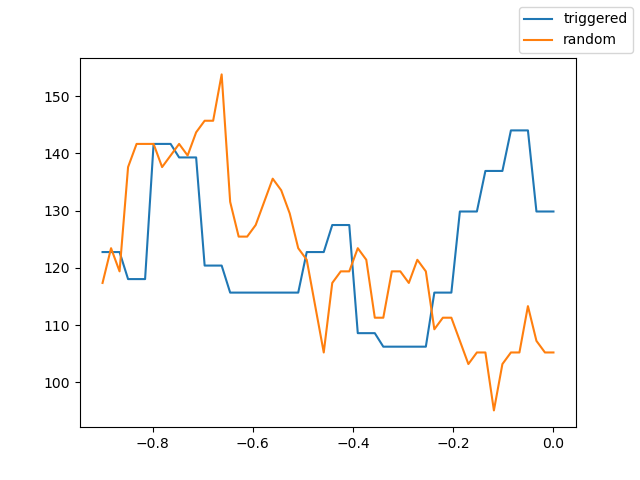

In [112]:
# example dimensions
# roi 15 -> [:, 13:, 11:13]
lead_beam = np.mean(lead_stack[:, 13:, 11:13], axis=(1, 2))
lead_xaxis = np.linspace(lead_beam.size * (-1 / 60), 0, lead_beam.size)
lead_beam_fig, lead_beam_ax = plt.subplots(1)
lead_beam_ax.plot(lead_xaxis, lead_beam, label="triggered")

random_lead_beam = np.mean(random_lead_stack[:, 13:, 11:13], axis=(1, 2))
lead_beam_ax.plot(lead_xaxis, random_lead_beam, label="random")
lead_beam_fig.legend()